In [1]:
# Cell 1: Setup and Imports
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model

# Set random seeds for reproducibility - we want same results every time
np.random.seed(42)
tf.random.set_seed(42)

# Verify GPU is available (should print something)
print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.19.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
# Cell 2: Load and Prepare MNIST Dataset
# Load the dataset (60,000 training, 10,000 test images)
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()

# Normalize pixel values from [0, 255] to [0, 1] range
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Add channel dimension: (28,28) -> (28,28,1) for CNN input
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

print(f"✅ Training data shape: {x_train.shape}")  # Should be (60000, 28, 28, 1)
print(f"✅ Test data shape: {x_test.shape}")      # Should be (10000, 28, 28, 1)
print(f"✅ Pixel value range: [{x_train.min():.2f}, {x_train.max():.2f}]")

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
✅ Training data shape: (60000, 28, 28, 1)
✅ Test data shape: (10000, 28, 28, 1)
✅ Pixel value range: [0.00, 1.00]


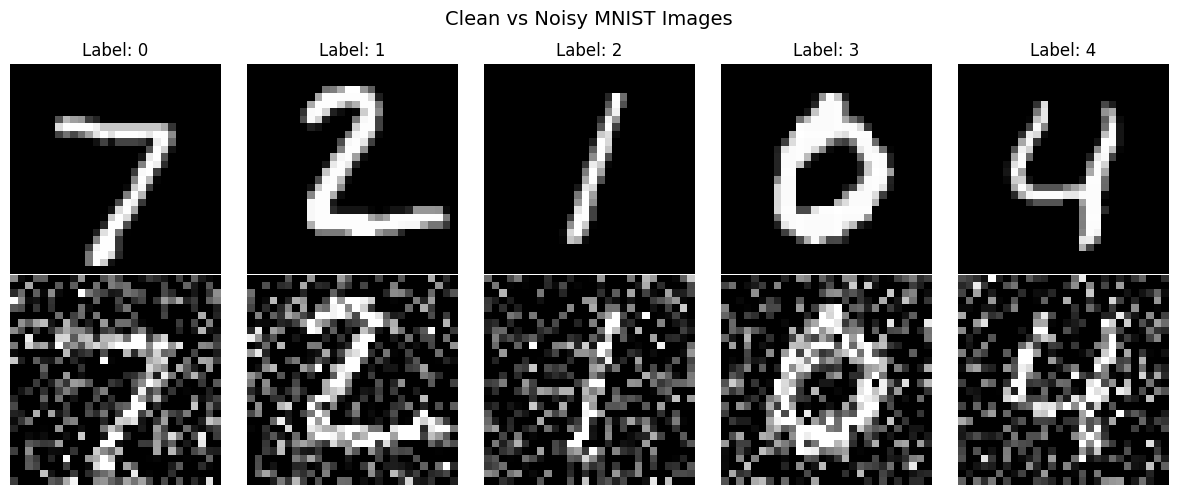

In [3]:
# Cell 3: Add Gaussian Noise to Images
def add_gaussian_noise(images, noise_factor=0.4):
    """
    Adds random Gaussian noise to images
    noise_factor controls noise intensity (0.0 = clean, 1.0 = very noisy)
    """
    # Generate random noise with same shape as images
    noise = noise_factor * np.random.normal(loc=0.0, scale=1.0, size=images.shape)
    # Add noise and clip values to stay in valid range [0, 1]
    noisy_images = images + noise
    return np.clip(noisy_images, 0.0, 1.0)

# Create noisy versions of our dataset
x_train_noisy = add_gaussian_noise(x_train)
x_test_noisy = add_gaussian_noise(x_test)

# Visualize some examples to see the effect
plt.figure(figsize=(12, 5))
for i in range(5):
    # Clean image
    plt.subplot(2, 5, i+1)
    plt.imshow(x_test[i].squeeze(), cmap='gray')
    if i == 0: plt.ylabel('Clean', fontsize=12)
    plt.title(f'Label: {i}')
    plt.axis('off')

    # Noisy image
    plt.subplot(2, 5, i+6)
    plt.imshow(x_test_noisy[i].squeeze(), cmap='gray')
    if i == 0: plt.ylabel('Noisy', fontsize=12)
    plt.axis('off')

plt.suptitle('Clean vs Noisy MNIST Images', fontsize=14)
plt.tight_layout()
plt.show()

In [4]:
# Cell 4: Build the Convolutional Autoencoder Architecture
def build_conv_autoencoder():
    """
    Builds the exact architecture from the research paper
    """
    # Input layer - expects 28x28 grayscale images
    input_img = layers.Input(shape=(28, 28, 1), name="input")

    # --- ENCODER: Compresses image to latent space ---
    # Layer 1: Conv2D (32 filters, 3x3 kernel, ReLU activation, same padding)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same', name="conv1")(input_img)

    # Layer 2: MaxPooling (2x2 pool, stride 2) - reduces dimensions to 14x14
    x = layers.MaxPooling2D((2, 2), strides=2, padding='same', name="pool1")(x)

    # Layer 3: Conv2D (32 filters, 3x3 kernel, ReLU activation, same padding)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same', name="conv2")(x)

    # Layer 4: MaxPooling (2x2 pool, stride 2) - reduces dimensions to 7x7
    encoded = layers.MaxPooling2D((2, 2), strides=2, padding='same', name="latent_space")(x)

    # --- DECODER: Reconstructs image from latent space ---
    # Layer 5: Conv2DTranspose (32 filters, 2x2 kernel, stride 2) - upsamples to 14x14
    x = layers.Conv2DTranspose(32, (2, 2), strides=2, activation='relu', padding='same', name="trans_conv1")(encoded)

    # Layer 6: Conv2DTranspose (32 filters, 2x2 kernel, stride 2) - upsamples to 28x28
    x = layers.Conv2DTranspose(32, (2, 2), strides=2, activation='relu', padding='same', name="trans_conv2")(x)

    # Layer 7: Conv2D (1 filter, 3x3 kernel, sigmoid activation) - final output layer
    decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same', name="output")(x)

    # Create the model
    autoencoder = Model(inputs=input_img, outputs=decoded, name="convolutional_autoencoder")
    return autoencoder

# Build the model
model = build_conv_autoencoder()

# Display architecture summary
print("="*70)
model.summary()
print("="*70)

# Verify parameter count
print(f"\n🎯 Total trainable parameters: {model.count_params():,}")
print(f"📊 Latent space shape: 7x7x32 = {7*7*32:,} features")

Model: "convolutional_autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 14, 14, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_space (MaxPooling2D)     │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ trans_conv1 (Conv2DTranspose)   │ (None, 14, 14, 32)     │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ trans_conv2 (Conv2DTranspose)   │ (None, 28, 28, 32)     │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Conv2D)                 │ (None, 28, 28, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,113 (70.75 KB)

 Trainable params: 18,113 (70.75 KB)

 Non-trainable params: 0 (0.00 B)


🎯 Total trainable parameters: 18,113
📊 Latent space shape: 7x7x32 = 1,568 features


In [5]:
# Cell 5: Compile the Model
# Use Adam optimizer and binary crossentropy loss as specified in paper
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[]  # We only care about loss for this project
)

print("✅ Model compiled successfully!")
print("📝 Optimizer: Adam")
print("📉 Loss function: Binary Crossentropy")

✅ Model compiled successfully!
📝 Optimizer: Adam
📉 Loss function: Binary Crossentropy


In [6]:

# Cell 6: Train the Model
import time

# Record start time
start_time = time.time()

# Train the model for 20 epochs as specified
print("🚀 Starting training for 20 epochs...")
print("⏱️ This will take about 1-2 minutes on GPU")

history = model.fit(
    x_train_noisy,  # Input: noisy images
    x_train,        # Target: clean images
    epochs=20,      # Train for 20 epochs
    batch_size=128,  # Process 128 images at a time
    shuffle=True,   # Shuffle data each epoch
    validation_data=(x_test_noisy, x_test),  # Use test set for validation
    verbose=1,      # Show progress bar
    # callbacks=[]  # We could add early stopping here, but 20 epochs is fine
)

# Calculate training time
elapsed_time = time.time() - start_time
print(f"\n✅ Training completed in {elapsed_time:.1f} seconds")
print(f"📊 Final validation loss: {history.history['val_loss'][-1]:.4f}")

# Save the trained model to your Google Drive
# First, mount your drive (uncomment the next two lines on first run):
# from google.colab import drive
# drive.mount('/content/drive')

# Save model (you can uncomment this after mounting drive):
# model.save('/content/drive/MyDrive/denoising_autoencoder.h5')
# print("💾 Model saved to Google Drive")


🚀 Starting training for 20 epochs...
⏱️ This will take about 1-2 minutes on GPU
Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 0.3138 - val_loss: 0.1087
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.1072 - val_loss: 0.1007
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.1010 - val_loss: 0.0977
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0984 - val_loss: 0.0961
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0968 - val_loss: 0.0950
Epoch 6/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0958 - val_loss: 0.0942
Epoch 7/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0950 - val_loss: 0.0936
Epoch 8/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0944 - val_loss: 0.0931
Epoch 9/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0939 - val_loss: 0.0926
Epoch 10/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0934 - val_loss: 0.0922
Epoch 11/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - lo

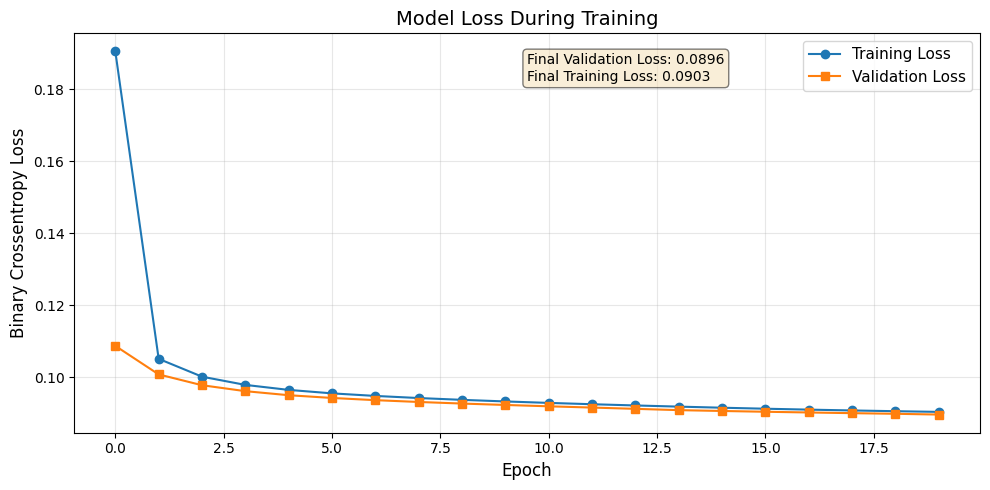


🎯 Target validation loss (from paper): 0.0871
📈 Your validation loss: 0.0896
✅ Excellent! Your model performed similarly to the research paper!


In [7]:
# Cell 7: Plot Training History
plt.figure(figsize=(10, 5))

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='s')

plt.title('Model Loss During Training', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Binary Crossentropy Loss', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

# Add text box with final values
final_train = history.history['loss'][-1]
final_val = history.history['val_loss'][-1]
plt.text(0.5, 0.95, f'Final Validation Loss: {final_val:.4f}\nFinal Training Loss: {final_train:.4f}',
         transform=plt.gca().transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

print(f"\n🎯 Target validation loss (from paper): 0.0871")
print(f"📈 Your validation loss: {final_val:.4f}")
if final_val < 0.10:
    print("✅ Excellent! Your model performed similarly to the research paper!")
else:
    print("💡 Good effort! Try training for 5-10 more epochs or check your noise level")

🔮 Generating predictions on test set...
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


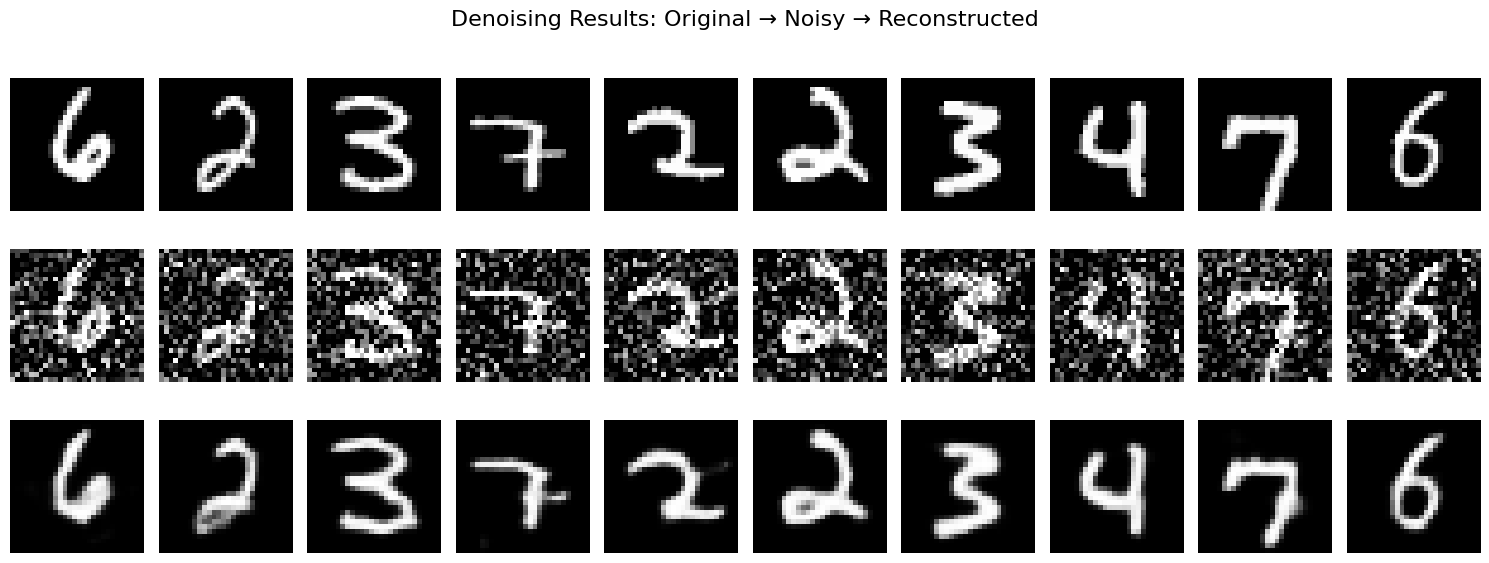


✅ Visualization complete! Compare the noisy vs denoised images.


In [8]:
# Cell 8: Test the Model and Visualize Results
# Use the trained model to denoise test images
print("🔮 Generating predictions on test set...")
denoised_images = model.predict(x_test_noisy, verbose=1)

# Create a comprehensive visualization
plt.figure(figsize=(15, 6))

# Select 10 random test images
np.random.seed(42)  # For reproducible visualization
indices = np.random.choice(len(x_test), 10, replace=False)

for i, idx in enumerate(indices):
    # Original clean image
    plt.subplot(3, 10, i+1)
    plt.imshow(x_test[idx].squeeze(), cmap='gray')
    if i == 0: plt.ylabel('Original', fontsize=12, labelpad=20)
    plt.axis('off')

    # Noisy image (input to model)
    plt.subplot(3, 10, i+11)
    plt.imshow(x_test_noisy[idx].squeeze(), cmap='gray')
    if i == 0: plt.ylabel('Noisy Input', fontsize=12, labelpad=20)
    plt.axis('off')

    # Denoised output (model prediction)
    plt.subplot(3, 10, i+21)
    plt.imshow(denoised_images[idx].squeeze(), cmap='gray')
    if i == 0: plt.ylabel('Denoised Output', fontsize=12, labelpad=20)
    plt.axis('off')

plt.suptitle('Denoising Results: Original → Noisy → Reconstructed',
             fontsize=16, y=0.98)
plt.tight_layout()
plt.show()

print("\n✅ Visualization complete! Compare the noisy vs denoised images.")

In [9]:
# Cell 9: Final Model Evaluation
# Calculate loss on test set
test_loss = model.evaluate(x_test_noisy, x_test, verbose=0)
print(f"🎯 Final Test Loss: {test_loss:.4f}")

# Compare with a simple baseline: what if we just returned the noisy image as-is?
baseline_loss = tf.keras.losses.binary_crossentropy(
    x_test_noisy.flatten(), x_test.flatten()
).numpy().mean()
print(f"📊 Baseline (No Processing) Loss: {baseline_loss:.4f}")

# Calculate improvement
improvement = (baseline_loss - test_loss) / baseline_loss * 100
print(f"📈 Improvement over baseline: {improvement:.1f}%")

# Sample prediction on a single image for demonstration
sample_idx = 0
sample_noisy = x_test_noisy[sample_idx:sample_idx+1]
sample_denoised = model.predict(sample_noisy, verbose=0)

print("\n" + "="*60)
print("SUMMARY")
print("="*60)
print(f"✅ Model trained successfully for 20 epochs")
print(f"✅ Validation loss: {final_val:.4f}")
print(f"✅ Test loss: {test_loss:.4f}")
print(f"✅ Parameters: {model.count_params():,}")
print(f"✅ Improvement over baseline: {improvement:.1f}%")
print("="*60)


🎯 Final Test Loss: 0.0896
📊 Baseline (No Processing) Loss: 2.2113
📈 Improvement over baseline: 95.9%

SUMMARY
✅ Model trained successfully for 20 epochs
✅ Validation loss: 0.0896
✅ Test loss: 0.0896
✅ Parameters: 18,113
✅ Improvement over baseline: 95.9%


In [10]:
# Cell 10
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

def calculate_metrics(clean, noisy, denoised):
    """Calculate PSNR and SSIM for a sample of images"""
    psnr_noisy = []
    psnr_denoised = []
    ssim_noisy = []
    ssim_denoised = []

    # Calculate for first 100 test images (faster)
    for i in range(100):
        # PSNR
        psnr_noisy.append(psnr(clean[i], noisy[i], data_range=1))
        psnr_denoised.append(psnr(clean[i], denoised[i], data_range=1))

        # SSIM (need to squeeze to remove channel dimension)
        ssim_noisy.append(ssim(clean[i].squeeze(), noisy[i].squeeze(), data_range=1))
        ssim_denoised.append(ssim(clean[i].squeeze(), denoised[i].squeeze(), data_range=1))

    return {
        "PSNR Noisy": np.mean(psnr_noisy),
        "PSNR Denoised": np.mean(psnr_denoised),
        "SSIM Noisy": np.mean(ssim_noisy),
        "SSIM Denoised": np.mean(ssim_denoised)
    }

# Calculate metrics
metrics = calculate_metrics(x_test, x_test_noisy, denoised_images)

print("="*60)
print("ADVANCED IMAGE QUALITY METRICS")
print("="*60)
print(f"PSNR - Noisy:  {metrics['PSNR Noisy']:.2f} dB")
print(f"PSNR - Denoised: {metrics['PSNR Denoised']:.2f} dB")
print(f"Improvement: +{metrics['PSNR Denoised']-metrics['PSNR Noisy']:.2f} dB")
print()
print(f"SSIM - Noisy:  {metrics['SSIM Noisy']:.4f}")
print(f"SSIM - Denoised: {metrics['SSIM Denoised']:.4f}")
print(f"Improvement: +{metrics['SSIM Denoised']-metrics['SSIM Noisy']:.4f}")
print("="*60)

ADVANCED IMAGE QUALITY METRICS
PSNR - Noisy:  11.02 dB
PSNR - Denoised: 20.93 dB
Improvement: +9.91 dB

SSIM - Noisy:  0.4269
SSIM - Denoised: 0.8856
Improvement: +0.4587


In [13]:
model.save_weights("autoencoder_1.weights.h5")
print("Weights saved!")

Weights saved!


In [16]:
model1 = build_conv_autoencoder()       # rebuild architecture
model1.load_weights("autoencoder_1.weights.h5")
print("Weights loaded!")


Weights loaded!


🔮 Generating predictions on test set...
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


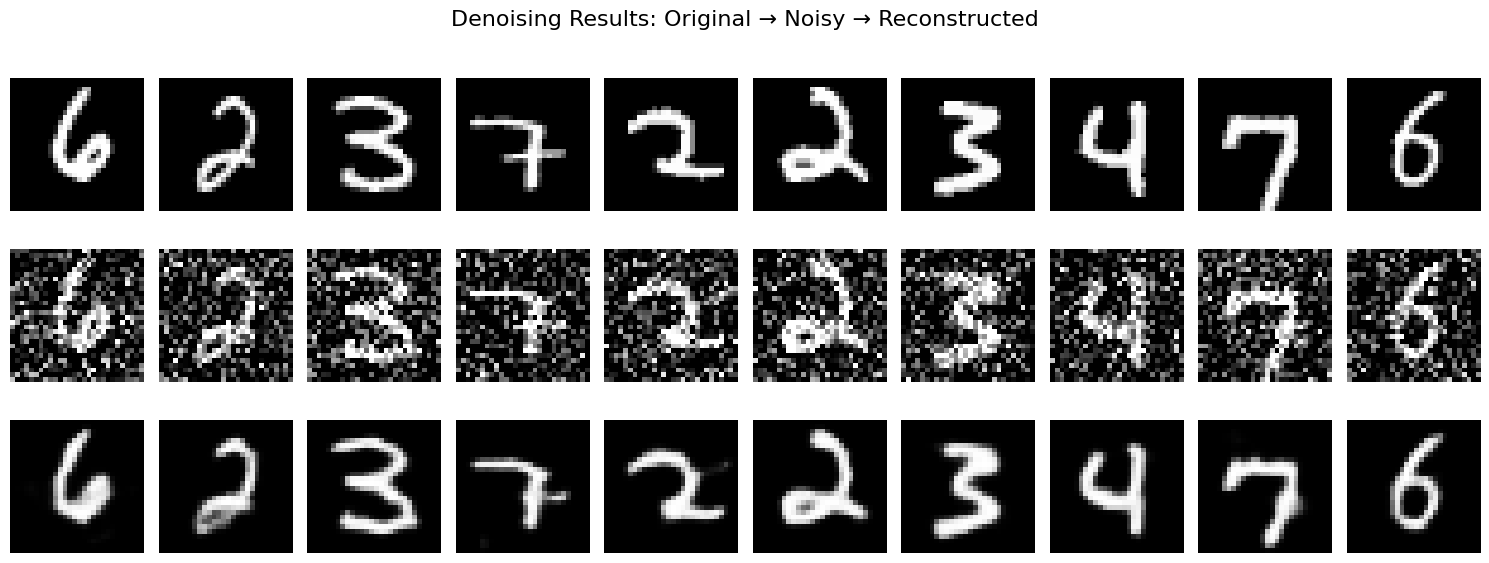


✅ Visualization complete! Compare the noisy vs denoised images.


In [17]:
# Cell 8: Test the Model and Visualize Results
# Use the trained model1 to denoise test images
print("🔮 Generating predictions on test set...")
denoised_images = model1.predict(x_test_noisy, verbose=1)

# Create a comprehensive visualization
plt.figure(figsize=(15, 6))

# Select 10 random test images
np.random.seed(42)  # For reproducible visualization
indices = np.random.choice(len(x_test), 10, replace=False)

for i, idx in enumerate(indices):
    # Original clean image
    plt.subplot(3, 10, i+1)
    plt.imshow(x_test[idx].squeeze(), cmap='gray')
    if i == 0: plt.ylabel('Original', fontsize=12, labelpad=20)
    plt.axis('off')

    # Noisy image (input to model1)
    plt.subplot(3, 10, i+11)
    plt.imshow(x_test_noisy[idx].squeeze(), cmap='gray')
    if i == 0: plt.ylabel('Noisy Input', fontsize=12, labelpad=20)
    plt.axis('off')

    # Denoised output (model1 prediction)
    plt.subplot(3, 10, i+21)
    plt.imshow(denoised_images[idx].squeeze(), cmap='gray')
    if i == 0: plt.ylabel('Denoised Output', fontsize=12, labelpad=20)
    plt.axis('off')

plt.suptitle('Denoising Results: Original → Noisy → Reconstructed',
             fontsize=16, y=0.98)
plt.tight_layout()
plt.show()

print("\n✅ Visualization complete! Compare the noisy vs denoised images.")

In [ ]:
model.